In [1]:
# standard imports
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', 15)

In [2]:
# function used to query each type of event from The Graph
def query_theGraph_epoch(raw_query, field_name, url, verbose=False):

    query_parts =raw_query.split(')')
    paginator = ", where: {}" 
    n = 0
    records = []
    while n < 1000:
        if (n == 0):
            # order by blockNumber to get all events, as deafult ordering is by id
            query = 'query '+query_parts[0] + 'orderBy:endBlock, where:{id:"0"})' + query_parts[1]
        else:
            query = 'query '+query_parts[0]+ 'orderBy:endBlock, where: {endBlock_gt: ' + str(indexer) + '})'+query_parts[1]

        if verbose:
            print(query)

        r = requests.post(url, json = {'query':query})

        try:
            d = json.loads(r.content)['data'][field_name]
        except:
            print(r.content)
            errors = json.loads(r.content)['errors']
            print(errors)
            for e in errors:
                print(e['message'])

        #print(f'results {len(d)}')
        records.extend(d)
        #print(f'total {len(records)}')
        try:
            indexer = d[-1]['endBlock']
            print(indexer)
        except:
            print('noblock')
        
        n += 1
        if len(d) < 99 and n > 1:
            break
        
    return pd.DataFrame(records)

In [21]:
#get subgraphs data
url = 'https://api.thegraph.com/subgraphs/name/jesseptao/graph-total-supply-experiment'

epoch_query = '''query{
	epoches(){
    id
    signalledTokens
    stakeDeposited
    totalQueryFees
    curatorQueryFees
    totalRewards
    endBlock
    totalSupply
  }
}
'''

field_name = 'epoches'

epoch_df = query_theGraph_epoch(epoch_query, field_name, url, False)

11453414
12118014
12510128


In [22]:
epoch_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,totalSupply
0,0,0,0,0,0,0,11453414,10000000000000000000000000000
1,1,0,10000000000000000000,0,0,0,11460060,0
2,2,0,0,0,0,0,11466706,0
3,3,0,2137573000000000000000000,0,0,0,11473352,0
4,4,244919450103834483981271,72326775000000000000000000,0,0,0,11479998,-113142138444810044546497
...,...,...,...,...,...,...,...,...
155,155,0,761569774966703436035,0,0,296162411869404064142930,12483544,292100666158053960020309
156,156,0,16027724201965711659636,24730807181914933911,1779642531009578457,358480552388392764284243,12490190,355272178138019509699764
157,157,0,11733257227728295279607,7443601003678978832,0,315343388349703805151775,12496836,308688896857498009474906
158,158,0,53590572940201961387,3591066044169025485161,212570032370876940480,603422792018319312461115,12503482,599057026257433356991453


In [23]:
epoch_df['totalSupply'] = epoch_df['totalSupply'].astype(float)
epoch_df['totalSupply'] = epoch_df['totalSupply']/10e18
epoch_df['total_supply'] = epoch_df['totalSupply'].cumsum()
epoch_df.drop('totalSupply', axis=1, inplace = True)
epoch_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,total_supply
0,0,0,0,0,0,0,11453414,1.000000e+09
1,1,0,10000000000000000000,0,0,0,11460060,1.000000e+09
2,2,0,0,0,0,0,11466706,1.000000e+09
3,3,0,2137573000000000000000000,0,0,0,11473352,1.000000e+09
4,4,244919450103834483981271,72326775000000000000000000,0,0,0,11479998,9.999887e+08
...,...,...,...,...,...,...,...,...
155,155,0,761569774966703436035,0,0,296162411869404064142930,12483544,1.010351e+09
156,156,0,16027724201965711659636,24730807181914933911,1779642531009578457,358480552388392764284243,12490190,1.010386e+09
157,157,0,11733257227728295279607,7443601003678978832,0,315343388349703805151775,12496836,1.010417e+09
158,158,0,53590572940201961387,3591066044169025485161,212570032370876940480,603422792018319312461115,12503482,1.010477e+09


In [6]:
from sklearn.linear_model import LinearRegression
supply_lr = LinearRegression().fit(epoch_df[['id']], epoch_df['total_supply'])
print('Coefficient:' + str(supply_lr.coef_), 'Intercept:' + str(supply_lr.intercept_))

Coefficient:[70931.79435253] Intercept:999274256.2898912


In [7]:
lr_df = pd.DataFrame(np.zeros(shape=(509,9)), columns=epoch_df.columns, index=range(0,509))
lr_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,totalSupply,total_supply
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
lr_df['total_supply'] = supply_lr.coef_*lr_df.index + supply_lr.intercept_
lr_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,totalSupply,total_supply
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.992743e+08
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.993452e+08
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.994161e+08
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.994871e+08
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.995580e+08
...,...,...,...,...,...,...,...,...,...
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035024e+09
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035095e+09
506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035166e+09
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035237e+09


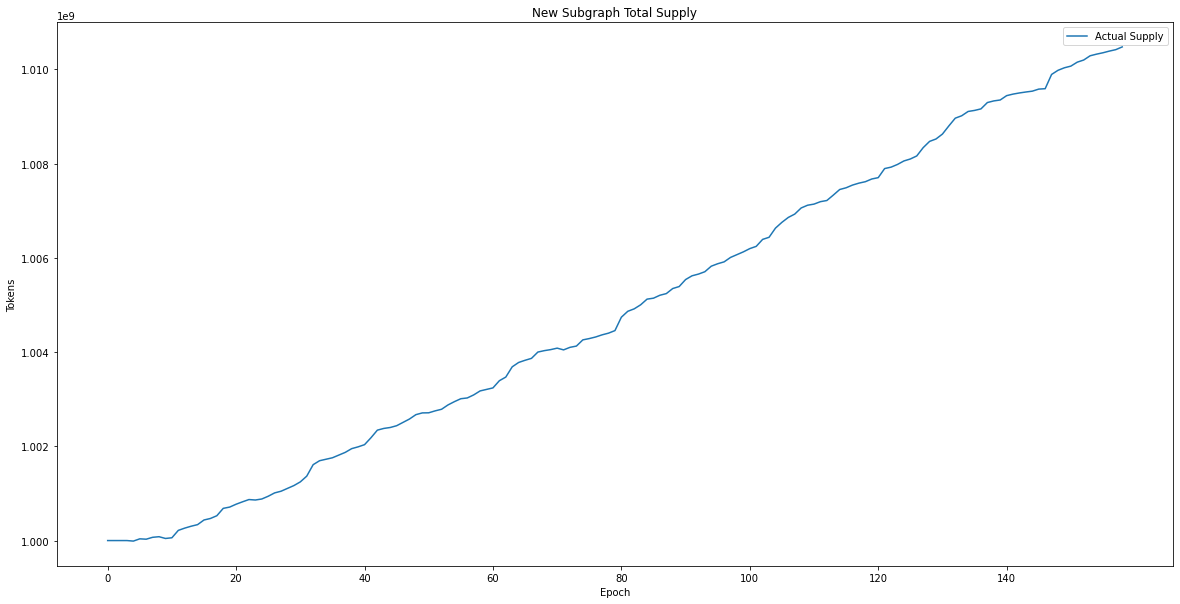

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(epoch_df['id'], epoch_df['total_supply'])
plt.legend(['Actual Supply', 'Predicted Supply'])
plt.xticks(range(0, 160, 20))
plt.xlabel('Epoch')
plt.ylabel('Tokens')
plt.title('New Subgraph Total Supply');

In [24]:
epoch_df.to_csv('./new_subgraph_supply.csv')